In [ ]:
#|default_exp pipeline

In [ ]:
%load_ext autoreload
%autoreload 2
from ipynb_path import *

In [ ]:
#| export
from __future__ import annotations
import relax
from relax.import_essentials import *
from relax.explain import prepare_cf_module, Explanation
from relax.methods import *
from relax.ml_model import *
from privacy.watermark import batched_watermark, keras2haiku, hard_kl_divergence, WatermarkConfig
from privacy.attack.extract import (
    QueryModelExtraction,
    ModelExtractionCF,
    DualCFAttack,
    agreement,
    get_gen_fn
)
from privacy.logger import *
from privacy.detect import *
from pprint import pprint
import wandb
import einops
import jax.tree_util as jt

/home/birk/mambaforge/lib/python3.10/site-packages/beartype/_util/hint/pep/utilpeptest.py:311: BeartypeDecorHintPep585DeprecationWarning: PEP 484 type hint typing.Tuple[typing.Optional[jax.Array], ...] deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprecations
  warn(


In [ ]:
#| export
def generate_exp(
    cf_module: CFModule,  # CF module used to generate CFs
    dm: relax.DataModule,  # Data module
    pred_fn: Callable[[Array], Array],  # Model prediction function
    use_cached: bool = True,  # Whether to use cached CFs
    cached_dir: str = "experiments",  # Directory to cache CFs
    rng_key: jrand.PRNGKey = jrand.PRNGKey(0),  # Random number generator
) -> tuple[Explanation, CFModule]:
    """Generate CF explanations and save them to disk."""
    exp_dir = Path(cached_dir) / cf_module.name / dm.name

    if use_cached and exp_dir.exists():
        cf_module = prepare_cf_module(cf_module, dm, pred_fn=pred_fn)
        exp = Explanation.load_from_path(exp_dir)
        exp.pred_fn = pred_fn
    else:
        exp = relax.generate_cf_explanations(
            cf_module, dm, pred_fn=pred_fn, rng_key=rng_key
        )
        exp.save(exp_dir)
    return exp, cf_module


In [ ]:
dm = relax.load_data('dummy')
ml_module = relax.load_ml_module('dummy')
cf_module = DiverseCF({'lambda_1': 10.})
exp, cf_module = generate_exp(cf_module, dm, ml_module.pred_fn, use_cached=False)
exp_1, _ = generate_exp(cf_module, dm, ml_module.pred_fn, use_cached=True)
assert jnp.array_equal(exp.cfs, exp_1.cfs)
assert jnp.array_equal(exp.ys, exp_1.ys)
assert jnp.array_equal(exp.xs, exp_1.xs)

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/birk/mambaforge/lib/python3.10/site-packages/relax/explain.py:141: UserWarning: `ml_module_path` is not provided. Setting `pred_fn=None`.
  warnings.warn("`ml_module_path` is not provided. Setting `pred_fn=None`.")


In [ ]:
#| export
@dataclass
class PipelineOutput:
    exp: Explanation
    w_exp: Explanation
    cf_module: CFModule
    extracted_model: MLModule
    detect_results: dict[str, float]

In [ ]:
#| export
def pipeline(
    dm: relax.DataModule,
    cf_module: CFModule,
    attack_fn: Callable,  # Function to perform the attack
    n_queries: int,  # Number of queries to the model
    ml_module: MLModule = None,  # ML module
    logger: Logger = None,  # Logger
    watermark_kargs_or_config: dict | WatermarkConfig = None,  # Keyword arguments for watermarking
    train_kwargs: dict = None,  # Keyword arguments for training the attack model
    detect_config: dict | DetectionConfig = None,  # Keyword arguments for watermark detection
    use_cached: bool = False,  # Whether to use cached CFs (TODO: Don't use this for now)
    use_watermark_to_extract: bool = True,  # Whether to use watermarked explanations to extract the model
    rng_key: jrand.PRNGKey = jrand.PRNGKey(0),  # Random number generator
):
    """Performs model extraction attack pipeline, including CF generation, watermarking, extraction, and watermark detection.""" 
    
    # train ml model and generate cf explanations
    if ml_module is None:
        print("Training ML model for DataModule...")
        ml_module = relax.MLModule().train(dm, epochs=50, batch_size=32, verbose=0)
    # init logger
    logger = Logger() if logger is None else logger
    
    print("Generating CF explanations...")
    exp, cf_module = generate_exp(cf_module, dm, ml_module.pred_fn, 
                                  use_cached=use_cached, rng_key=rng_key)
    # 1. perform watermarking
    print("Performing watermarking...")
    net, params = keras2haiku(ml_module.model, ml_module.config, dm.xs[:1].shape)
    w_conf = WatermarkConfig(**watermark_kargs_or_config) if isinstance(watermark_kargs_or_config, dict) else watermark_kargs_or_config
    w_cfs, loss = batched_watermark(exp, conf=w_conf, pred_model=net, 
                                    pred_params=params, return_loss=True)
    train_indices, test_indices = map(jnp.array, (exp.train_indices, exp.test_indices))
    w_exp = exp.copy()
    w_exp._cfs = w_exp.cfs.at[test_indices].set(w_cfs)
    chex.assert_equal_shape([exp.cfs, w_exp.cfs])
    assert np.allclose(exp.cfs[train_indices], w_exp.cfs[train_indices])
    assert (
        np.abs(exp.cfs[test_indices] - w_exp.cfs[test_indices]).max() < w_conf.eps + 1e-3
    ), f"delta_w should not exceed eps={w_conf.eps}, " \
       f"but got {np.abs(exp.cfs[test_indices] - w_exp.cfs[test_indices]).max()}."
    
    assert np.allclose(w_exp.xs, exp.xs)
    # plot loss
    loss = jt.tree_map(lambda x: x.mean(0), loss)
    # logger.log({'poison': l1, 'validity': l2}, print=False)
    if len(loss) > 0: # skip if loss is empty
        logger.log_losses({'Bilevel Loss': loss})
    
    # log validity between original and watermarked CFs
    validity = (
        ml_module.pred_fn(exp.cfs[test_indices]).round() == 
        ml_module.pred_fn(w_cfs).round()
    ).sum() / (w_cfs.shape[0] * w_cfs.shape[1] * 2)
    logger.log({'validity': validity})
    
    # log original and watermarked CFs
    logger.log({
        "Original CFs": relax.benchmark_cfs([exp]),
        "Watermarked CFs": relax.benchmark_cfs([w_exp])
    })

    logger.log_exps(exp, w_exp)
    
    # 2. attack
    print("Performing model extraction attack...")
    if train_kwargs is None:
        train_kwargs = {
            "epochs": 100,
            "validation_split": 0.0,
            "batch_size": 32,
            "verbose": False,
        }

    if hasattr(attack_fn, 'set_cf_generate_fn'):
        print("Setting CF generation function...")
        attack_fn.set_cf_generate_fn(get_gen_fn(cf_module))

    attack_key, rng_key = jrand.split(rng_key)
    extracted_model = attack_fn(
        w_exp if use_watermark_to_extract else exp,
        n_queries=n_queries,
        train_kwargs=train_kwargs,
        shuffle=True,
        rng_key=attack_key
    )

    extracted_agreement = agreement(
        w_exp, extracted_model, w_exp["test"]["xs"]
    ).item()
    logger.log({"Extracted model agreement": extracted_agreement})

    # 3. detect watermark
    print("Detecting watermark...")
    w_cfs_ys = extracted_model.pred_fn(w_exp["test"]["cfs"])
    cfs_ys = extracted_model.pred_fn(exp["test"]["cfs"])
    
    detect_config = DetectionConfig(**detect_config) if isinstance(detect_config, dict) else detect_config
    ttest_res, y_diff = detect_watermark(exp["test"]["cfs"], w_exp["test"]["cfs"],
                                         extracted_model=extracted_model, config=detect_config)
    detect_result = {
        "p-value": ttest_res[1],
        "poisson_loss": hard_kl_divergence(w_cfs_ys, cfs_ys).mean(),
        "mean_difference": y_diff
    }
    
    logger.log(detect_result)

    # pprint(f"p-value: {ttest_res[1]: .4f}, mean: {ttest_res[0]: .4f}")
    # pprint(f"Poisson loss: {hard_kl_divergence(w_cfs_ys, cfs_ys).mean(): .4f}")
    # pprint(f"Mean difference: {y_diff: .4f}")

    return PipelineOutput(
        exp=exp, w_exp=w_exp, cf_module=cf_module, extracted_model=extracted_model,
        detect_results=detect_result
    )

In [ ]:
#| export
def attack_default_exps(
    default_dir: Path,
    dm: relax.DataModule,
    cf_module: CFModule,
    attack_fn: Callable,  # Function to perform the attack
    n_queries: int,  # Number of queries to the model
    ml_module: MLModule = None,  # ML module
    logger: Logger = None,  # Logger
    train_kwargs: dict = None,  # Keyword arguments for training the attack model
    detect_config: dict | DetectionConfig = None,  # Keyword arguments for watermark detection
    use_watermark_to_extract: bool = True,  # Whether to use watermarked explanations to extract the model
    rng_key: jrand.PRNGKey = jrand.PRNGKey(0),  # Random number generator
) -> PipelineOutput:
    """Use generated exp and w_exp to perform attacks."""

    # prepare cf module: it will regenerate cfs
    exp, cf_module = generate_exp(cf_module, dm, ml_module.pred_fn, 
                                  use_cached=False, rng_key=jrand.PRNGKey(0))
    
    data = pd.read_csv(Path(default_dir) / "data.csv", index_col=0)
    ys = data[data['type'] == 'xs']['output'].values
    data = data.drop(columns='output')
    xs = data[data['type'] == 'xs'].drop(columns='type').values
    B, K = xs.shape
    cfs = data[data['type'] == 'cfs'].drop(columns='type').values.reshape(B, -1, K)
    w_cfs = data[data['type'] == 'w_cfs'].drop(columns='type').values.reshape(B, -1, K)
    # exp = Explanation(cfs, pred_fn=None, xs=xs, ys=ys[:B])
    print("testset cfs shapes: ", cfs.shape, w_cfs.shape)
    test_indices = jnp.array(exp.test_indices)
    exp._cfs = exp.cfs.at[test_indices].set(cfs)
    w_exp = exp.copy()
    w_exp._cfs = w_exp.cfs.at[test_indices].set(w_cfs)
    # 2. attack
    print("Performing model extraction attack...")
    if train_kwargs is None:
        train_kwargs = {
            "epochs": 100,
            "validation_split": 0.0,
            "batch_size": 32,
            "verbose": False,
        }

    if hasattr(attack_fn, 'set_cf_generate_fn'):
        print("Setting CF generation function...")
        attack_fn.set_cf_generate_fn(get_gen_fn(cf_module))

    attack_key, rng_key = jrand.split(rng_key)
    extracted_model = attack_fn(
        w_exp if use_watermark_to_extract else exp,
        n_queries=n_queries,
        train_kwargs=train_kwargs,
        shuffle=True,
        rng_key=attack_key
    )

    extracted_agreement = agreement(
        w_exp, extracted_model, w_exp["test"]["xs"]
    ).item()
    logger.log({"Extracted model agreement": extracted_agreement})

    # 3. detect watermark
    print("Detecting watermark...")
    w_cfs_ys = extracted_model.pred_fn(w_exp["test"]["cfs"])
    cfs_ys = extracted_model.pred_fn(exp["test"]["cfs"])

    detect_config = DetectionConfig(**detect_config) if isinstance(detect_config, dict) else detect_config
    ttest_res, y_diff = detect_watermark(exp["test"]["cfs"], w_exp["test"]["cfs"],
                                         extracted_model=extracted_model, config=detect_config)

    detect_result = {
        "p-value": ttest_res[1],
        "poisson_loss": hard_kl_divergence(w_cfs_ys, cfs_ys).mean(),
        "mean_difference": y_diff
    }
    
    logger.log(detect_result)
    
    return PipelineOutput(
        exp=exp, w_exp=w_exp, cf_module=cf_module, extracted_model=extracted_model,
        detect_results=detect_result
    )

In [ ]:
dm = relax.load_data('titanic')
ml_module = relax.load_ml_module('titanic')
# cf_module = DiverseCF({'lambda_1': 10.})
cf_module = GrowingSphere()
exp = relax.generate_cf_explanations(
    cf_module, dm, pred_fn=ml_module.pred_fn, 
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
relax.benchmark_cfs([exp])

,,acc,validity,proximity
titanic,GrowingSphere,0.776655,1.0,27.073589


Generating CF explanations...


  0%|          | 0/100 [00:00<?, ?it/s]

Performing watermarking...


  0%|          | 0/50 [00:00<?, ?it/s]

validity: 1.0
Original CFs:                             acc  validity  proximity
titanic GrowingSphere  0.776655       1.0  26.948215
Watermarked CFs:                             acc  validity  proximity
titanic GrowingSphere  0.776655       1.0  26.956524
Performing model extraction attack...
Extracting model using 128 queries.
retrain_xs.shape: (256, 57); retrain_ys.shape: (256, 2)
Extracted model agreement: 0.9910314679145813
Detecting watermark...
p-value: 1.3455441917600418e-58
poisson_loss: 0.002358220750465989
mean_difference: 0.0013095152098685503


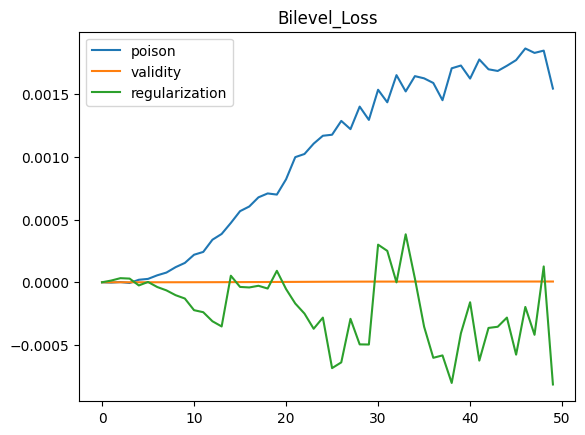

In [ ]:
# dm = relax.load_data('adult')
# ml_module = relax.load_ml_module('adult')
# cf_module = DiverseCF({'lambda_1': 10.})
attack_fn = ModelExtractionCF(MLModule({
    "loss": "binary_crossentropy", "metrics": ["accuracy"], 'lr': 0.01}))
w_conf = WatermarkConfig(
    batch_size=64, steps=50, eps=0.05, k=10, n_ensembels=4,
    perturb_categorical=False
)

output = pipeline(
    dm=dm, 
    cf_module=cf_module, 
    attack_fn=attack_fn, 
    ml_module=ml_module,
    n_queries=128, 
    train_kwargs={'epochs': 100, 'validation_split': 0., 'batch_size': 32, 'verbose': False},
    watermark_kargs_or_config=w_conf,
    use_watermark_to_extract=True,
    logger=Logger()
)


We have two problems:

1. **Overfitting**. The poison loss in the "training set" (during optimization) is 
larger than in the "test set" (during the detection).

2. **Undetectable**. The poison loss of extracted models using poisoned $D^\text{cf}$ 
is even smaller than extracted models without $D^\text{cf}$. 
